Compute only $\chi$ and F from data to get time frame of computing the essentials

In [1]:
# Import necessary libraries
import numpy as np
import glob

# Import external background functions
%run background_functions.py

In [2]:
# Import HCP data
# Importing all matrices with Numpy
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Generate an averaged matrix
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix
averaged_matrix = MatAv/len(matrices)

In [3]:
# Define desired settings
cutoff=0.5 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=4
M = averaged_matrix

In [4]:
# Compute the clique complex and Euler Characteristic
%time euler_characteristic, clique_complex = compute_euler(M,cutoff,max_dim)

CPU times: total: 15.6 ms
Wall time: 13.7 ms


In [5]:
# Generate the connectivity matrix L from the clique complex
%time inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

CPU times: total: 609 ms
Wall time: 260 ms


In [6]:
# Compute the Helmholtz free energy
%time U_min, p_Umin, S_max, p_Smax, Free_energy = free_energy(inverse_connectivity_matrix, 1)

C:\Users\cyril\Documents\GitHub\Free_energy_of_simplicial_complexes\background_functions.py:35: RuntimeWarning: overflow encountered in exp
  if new_value < current_value or np.random.rand() > np.exp((new_value - current_value) / temperature):


CPU times: total: 8.88 s
Wall time: 18.2 s


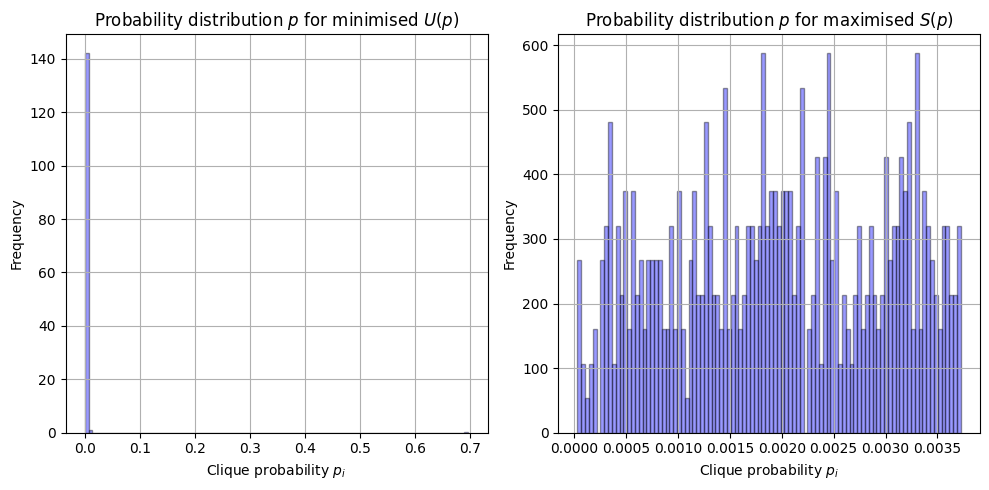

In [7]:
# Plotting the probability distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(p_Umin, bins=100, density=True, alpha=0.4, color='blue', edgecolor='black')
plt.xlabel('Clique probability $p_i$')
plt.ylabel('Frequency')
plt.title('Probability distribution $p$ for minimised $U(p)$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(p_Smax, bins=100, density=True, alpha=0.4, color='blue', edgecolor='black')
plt.xlabel('Clique probability $p_i$')
plt.ylabel('Frequency')
plt.title('Probability distribution $p$ for maximised $S(p)$')
plt.grid(True)

plt.tight_layout()
plt.show()

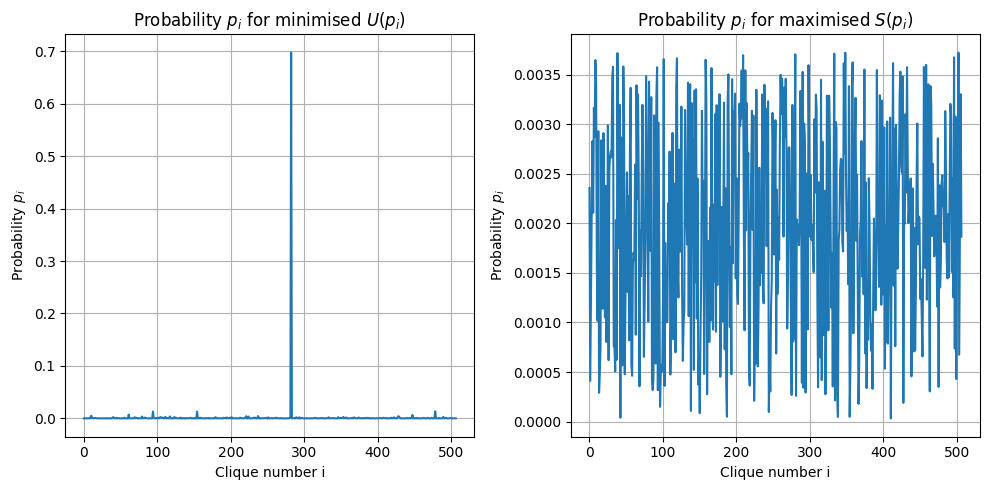

In [8]:
# Plotting the probability distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(p_Umin)
plt.xlabel('Clique number i')
plt.ylabel('Probability $p_i$')
plt.title('Probability $p_i$ for minimised $U(p_i)$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(p_Smax)
plt.xlabel('Clique number i')
plt.ylabel('Probability $p_i$')
plt.title('Probability $p_i$ for maximised $S(p_i)$')
plt.grid(True)

plt.tight_layout()
plt.show()

Compare sampling for alternative distributions, since the optimised value should converge to a constant minimum.

In [75]:
# Example for generating energy and entropy data from a given matrix
list_size = len(M)
num_iterations_energy = 2000
num_iterations_entropy = 1000
sampling_distributions = ['uniform', 'normal', 'poisson', 'chisquare', 'gamma', 'pareto', 'lognormal']
energy_probabilities = []
entropy_probabilities = []

for _ in sampling_distributions:
    initial_probabilities = generate_probability_list(list_size, _)
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, _ , -0.1, M, num_iterations_energy)
    # Maximum shannon entropy with simulated annealing
    entropy_history, current_probabilities_entropy = simulated_annealing_entropy(initial_probabilities, _ , -0.1, num_iterations_entropy)
    # Store probabilities type
    energy_probabilities.append(energy_history)
    entropy_probabilities.append(entropy_history)

In [77]:
# Maximum shannon entropy from uniform distribution
n = len(matrix)
p_Smax = np.ones(n) / n
max_entropy_value = shannon_entropy(p_Smax)
max_entropy = [max_entropy_value]*num_iterations_entropy

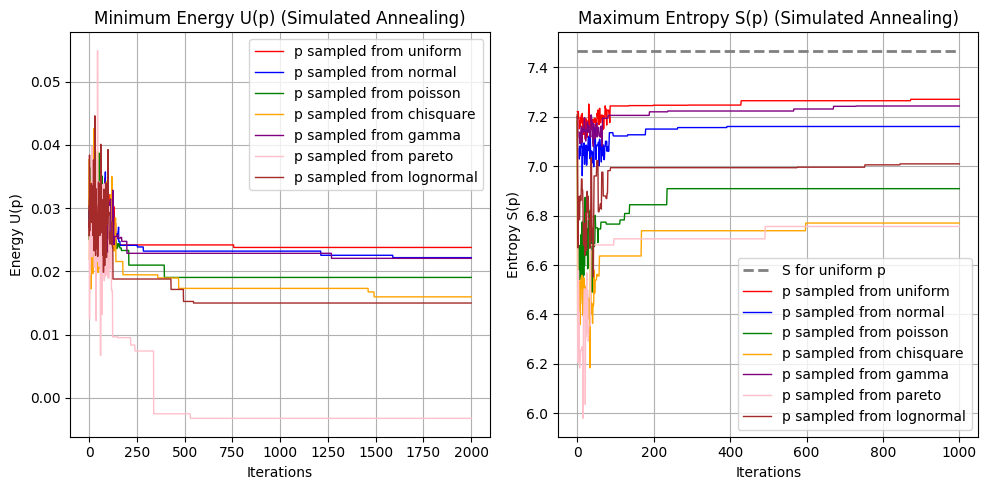

In [78]:
# Plotting the optimisation side by side
plt.figure(figsize=(10, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 2, 1)
for i in range(len(sampling_distributions)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Minimum Energy U(p) (Simulated Annealing)')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(max_entropy, color='grey', linestyle='--', linewidth = 2, label='S for uniform p')
for i in range(len(sampling_distributions)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Maximum Entropy S(p) (Simulated Annealing)')
plt.xlabel('Iterations')
plt.ylabel('Entropy S(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Pareto is the most efficient so compare pareto parameters to optimize. Explore genpareto to adjust more parameters.

In [81]:
# Example for generating energy and entropy data from a given matrix
list_size = len(M)
num_iterations_energy = 5000
num_iterations_entropy = 5000
energy_probabilities = []
entropy_probabilities = []
pareto_constants = [-0.1, -0.3, -0.6, -0.9]
cooling_rates = [0.1, 0.3, 0.6, 0.9, 0.99]

for pareto_constant in pareto_constants:
    initial_probabilities = generate_probability_list(list_size, 'genpareto')
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, 'genpareto' , pareto_constant, M, num_iterations_energy)
    # Store probabilities type
    energy_probabilities.append(energy_history)

for current_cooling_rate in cooling_rates:
    initial_probabilities = generate_probability_list(list_size, 'genpareto')
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, 'genpareto' , -0.1, M, num_iterations_energy, cooling_rate=current_cooling_rate)
    # Store probabilities type
    entropy_probabilities.append(energy_history)

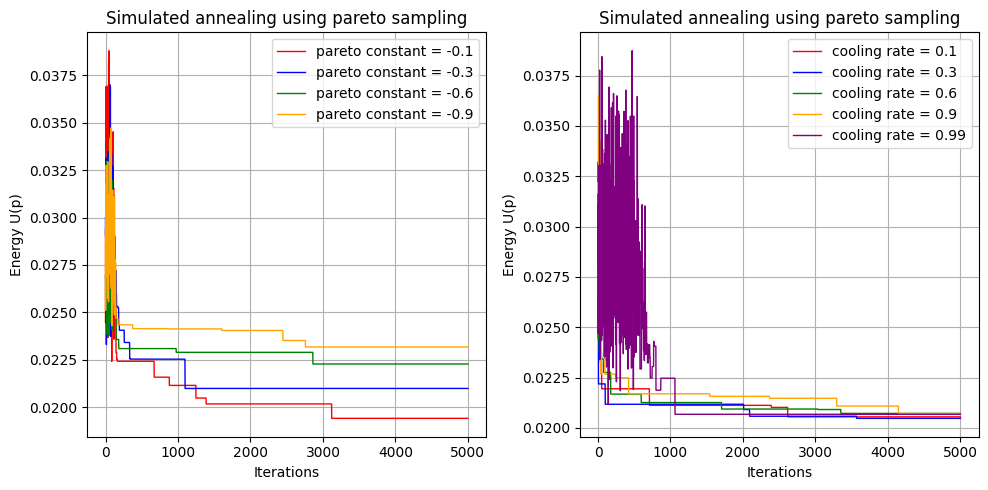

In [82]:
# Plotting the optimisation side by side
plt.figure(figsize=(10, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 2, 1)
for i in range(len(pareto_constants)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'pareto constant = {pareto_constants[i]}')
plt.title('Simulated annealing using pareto sampling')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(cooling_rates)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'cooling rate = {cooling_rates[i]}')
plt.title('Simulated annealing using pareto sampling')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

For all cooling rates there does not seem to be any updates that INCREASE the energy?? How come??
Answer: the acceptance probability was ill-defined. Now energy increases and entropy decreases are also accepted with some probability.
Note: however, the acceptance of worse solutions is specifically designed to escape local minima. However, in this case we generate a completely new vector for the clique probabilities so we don't stay close to a previously found minimum. Therefore, we cannot get stuck in a local minimum anyways.

Explore other optimisation techniques to improve this optimisation, since it is quite brute force. --> generate probability from degree, then adjust locally to update. 